In [1]:
%matplotlib inline
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.io import loadmat

from aux import loadmat_h5
from disp import set_font_size

TUNING_FILE = 'data/simple/ipi_freq_timecourses.npy'
CELL_FILE = 'data/christa/VLP_knownAUD_neurons_copiedFromFlyWireDatabase_20200617.xlsx'
# W_FILE = 'data/christa/allAudNeurons_connMat_noDupSyn.mat'
W_FILE = 'data/christa/allAudNeurons_connMat_noDupSyn_cleftFilt_20210603.mat'

FPS = 8.5

In [2]:
tuning_data = np.load(TUNING_FILE, allow_pickle=True)[0]

ipi = tuning_data['ipi']
ipi_rsps = tuning_data['ipi_rsps_means']

freq = tuning_data['freq']
freq_rsps = tuning_data['freq_rsps_means']

In [3]:
cell_df = pd.read_excel(CELL_FILE, engine='openpyxl')
cell_df[['short name', 'lineID for IPI/Freq tuning curves', 'Eckstein NT classification numeric']]

,short name,lineID for IPI/Freq tuning curves,Eckstein NT classification numeric
0,A1_L1,NaN,NaN
1,A1_L2,NaN,NaN
2,A1_L3,NaN,NaN
3,A1_R1,NaN,NaN
4,A1_R2,NaN,NaN
...,...,...,...
493,pC1as_R1,NaN,1.0
494,pC1as_R2,NaN,1.0
495,NaN,NaN,NaN
496,NaN,NaN,NaN


In [4]:
labels = np.array(cell_df['short name'])
line_ids = np.array(cell_df['lineID for IPI/Freq tuning curves'])  # floats/ints from 1 to 30 inclusive
signs = np.array(cell_df['Eckstein NT classification numeric'])

label2line = {label: line_id for label, line_id in zip(labels, line_ids)}
label2sign = {label: np.sign(sign) for label, sign in zip(labels, signs)}

In [5]:
w_th = 1

w_data = loadmat_h5(W_FILE)
labels_w = w_data['neuronNames'][:, 0]

w_raw = w_data['cxns_noDup']
w = w_raw.copy()
w[w_raw < w_th] = 0
w[np.isnan(w)] = 0

# add sign
sign_mat = np.zeros(w.shape)  # note this zeroes any weights without signs attached
for cl, label in enumerate(labels_w):
    if label in label2sign and not np.isnan(label2sign[label]):
        sign_mat[cl, :] = label2sign[label]
            
w = w*sign_mat  # multiply w by signs

In [6]:
for label in labels_w:  # fill any missing labels with nan
    if label not in label2line:
        label2line[label] = np.nan

How to get tuning curves idx associated w/ row i in w:

1. Get i'th label from label_w.
2. Look up line in label2line. I.e. line = label2line[label_w[i]].

In [7]:
def get_ipi_timecourses(label, verbose=False): # get idx
    line = label2line[label]
    if not np.isnan(line): 
        rsp = ipi_rsps[int(line - 1)]
        if rsp.shape[1] == 163:
            return np.concatenate([rsp, np.nan*np.zeros((len(ipi), 1))], axis=1)  # make sure there are 164 timesteps in response array
        else:
            return rsp
    else:
        if verbose:  print(f'No ipi responses for cell {label}')
        return None
    
def get_freq_timecourses(label, verbose=False): # get idx
    line = label2line[label]
    if not np.isnan(line): 
        rsp = freq_rsps[int(line - 1)]
        if rsp.shape[1] == 163:
            return np.concatenate([rsp, np.nan*np.zeros((len(freq), 1))], axis=1)  # make sure there are 164 timesteps in response array
        else:
            return rsp
    else:
        if verbose:  print(f'No freq responses for cell {label}')
        return None

In [8]:
def w2rgba(w_, w_min=-3, w_max=3):
    cmap = cm.get_cmap('PiYG')
    return cmap(w_/6 + .5)

Model emergence of tuning curve from upstream tuning via linear dynamical system

$$\tau \frac{dx_i}{dt} = -x_i + \sum_j W_{ij} x_j$$

Each target neuron (col in weight matrix) w/ corresponding tuning curve dataset gives distinct analysis to do. We take the tuning curve data for the target neuron, look up its upstream neighbors and their weights onto the target neuron, compute a model response using a linear dynamical system and the upstream responses, then recompute the tuning curve for the model responses.

Note: not all columns have corresponding tuning curve data. And when a neuron does have corresponding tuning curve data, not all of its upstream neighbors might have tuning curve data also.

In [9]:
# FREQ tuning
DT = 1/FPS
TAU = .5
INRNS = np.argsort((np.abs(w) > 0).sum(axis=0))[::-1]
INRNS_PLOT = []  #INRNS

labels_up_total_all = {}
labels_up_valid_all = {}
labels_up_missing_all = {}

rsp_err_all = {}
tuning_err_all = {}

tuning_curves_data_all = {}
tuning_curves_model_all = {}

labels_no_tuning = []
labels_no_upstream = []

n_skipped = 0

for inrn in INRNS:
    
    label = labels_w[inrn]
    
    t = np.arange(164)/FPS

    if np.isnan(label2line[label]):
        print(f'No FREQ tuning data for cell {label}')
        labels_no_tuning.append(label)
        rsp_err_all[label] = np.nan
        tuning_err_all[label] = np.nan
        n_skipped += 1
        continue
        
    # upstream inputs
    iup = w[:, inrn].nonzero()[0]  # idxs relative to w and labels_w
    w_up = w[iup, inrn]  # weights
    labels_up = labels_w[iup]  # labels
    lines_up = np.array([label2line[label_up] for label_up in labels_up])
    
    # subset of upstream inputs with tuning curve data (mask for previous 4 arrays)
    mvalid = ~np.isnan(lines_up)
    assert len(iup) == len(w_up) == len(labels_up) == len(lines_up)
    
    if np.sum(mvalid) == 0:
        print(f'No upstream FREQ tuning data for cell {label}')
        labels_no_upstream.append(label)
        rsp_err_all[label] = np.nan
        tuning_err_all[label] = np.nan
        n_skipped += 1
        continue
 
    labels_up_valid = labels_up[mvalid]  # labels of upstream cells w/ FREQ data
    labels_up_missing = labels_up[~mvalid]  # labels of upstream cells w/o FREQ data
 
    labels_up_total_all[label] = labels_up.copy()
    labels_up_valid_all[label] = labels_up_valid.copy()
    labels_up_missing_all[label] = labels_up_missing.copy()
    
    # weights corresponding to valid upstream labels
    w_up_valid = w_up[mvalid]
    w_scale = np.nanstd(w_up_valid) if len(w_up_valid) >= 2 else 1
    w_up_valid /= w_scale
    
    # target neuron's true freq time courses
    rsps_data = get_freq_timecourses(label)
    rsps_data /= np.nanstd(rsps_data)  # z-score across time & stims

    # upstream neuron freq time courses
    rsps_up_all = [get_freq_timecourses(label_up) for label_up in labels_up_valid]
    
    # run simulation for each FREQ
    rsps_model = np.nan * np.zeros((len(freq), len(t)))  # one row per FREQ
    for cfreq, freq_ in enumerate(freq):
        # get array of upstream neuron activities for this FREQ
        rsp_up = np.array([rsps_up[cfreq, :] for rsps_up in rsps_up_all])
        assert rsp_up.shape == (len(labels_up_valid), len(t)) or len(rsp_up) == 0
        
        r = np.nan * np.zeros(len(t))
        
        r[0] = 0

        for ct, t_ in enumerate(t[1:], 1):
            dr = (DT/TAU) * (-r[ct-1] + w_up_valid@rsp_up[:, ct])
            r[ct] = r[ct-1] + dr
        
        rsps_model[cfreq, :] = r.copy()
        
    rsps_model /= np.nanstd(rsps_model)  # z-score across time & stims
    
    rsp_err_all[label] = np.sqrt(np.nanmean((rsps_model - rsps_data)**2))
    
    # compute freq tuning curves for data and model
    mtuning = (5 <= t) & (t < 13)
    
    rsp_tavg_data = np.array([rsp_data[mtuning].sum()*DT for rsp_data in rsps_data])
    rsp_tavg_model = np.array([rsp_model[mtuning].sum()*DT for rsp_model in rsps_model])
    
    tuning_curves_data_all[label] = rsp_tavg_data.copy()
    tuning_curves_model_all[label] = rsp_tavg_model.copy()
       
    tuning_err_all[label] = np.sqrt(np.mean((rsp_tavg_data - rsp_tavg_model)**2))
    
    # input currents for each freq and true vs modeled output current for each freq
    if inrn not in INRNS_PLOT:
        continue
        
    fig = plt.figure(figsize=(17, 6), tight_layout=True)
    ax1 = fig.add_subplot(2, 6, 1)
    axs = np.array([
        [ax1] + [fig.add_subplot(2, 6, i, sharex=ax1, sharey=ax1) for i in range(2, 6)] + [fig.add_subplot(2, 6, 6)],
        [fig.add_subplot(2, 6, i, sharex=ax1, sharey=ax1) for i in range(7, 12)] + [fig.add_subplot(2, 6, 12)],
    ])

    for cfreq, (ax, freq_) in enumerate(zip(axs[0, :-1], freq)):  # loop over freqs
        # plot all upstream responses (i.e. inputs) colored by weight
        rsp_up = np.array([rsps_up[cfreq, :] for rsps_up in rsps_up_all])  # upstream responses at this freq
        assert len(rsp_up) == len(w_up_valid)

        for rsp_up_, w_ in zip(rsp_up, w_up_valid):
            ax.plot(t, rsp_up_, c=w2rgba(w_))

        ax.set_facecolor((.8, .8, .8))
        ax.set_title(f'{inrn}: {label}\n{len(w_up)} upstream\n{len(labels_up_valid)} valid, {len(labels_up_missing)} missing \nfreq = {freq_} Hz')
    
    # true vs modeled target neuron response (for all freqs)
    for cfreq, (ax, freq_) in enumerate(zip(axs[1, :-1], freq)):
        ax.plot(t, rsps_data[cfreq], c='k')
        ax.plot(t, rsps_model[cfreq], c='b')

        ax.set_xlabel('Time (s)')
        
    axs[1, 0].legend(['Data', 'Model'])

    axs[0, -1].scatter(lines_up[mvalid], w_up[mvalid], c=[w2rgba(w_/w_scale) for w_ in w_up[mvalid]])
    axs[0, -1].scatter(np.repeat(35, (~mvalid).sum()), w_up[~mvalid], facecolors='none', edgecolors=[w2rgba(w_/w_scale) for w_ in w_up[~mvalid]])
    axs[0, -1].set_facecolor((.8, .8, .8))
    axs[0, -1].axhline(0, color='gray', ls='--')
    axs[0, -1].axvline(label2line[label], c='k')
    axs[0, -1].set_xlim(0, 36)
    axs[0, -1].grid()

    axs[0, -1].set_xlabel('Line')
    axs[0, -1].set_ylabel('Weight')
    axs[0, -1].set_title(f'Targ line: {int(round(label2line[label]))}\nInput lines:\n{sorted(np.unique([int(line_up) for line_up in lines_up if not np.isnan(line_up)]))}')
    
    axs[1, -1].plot(freq, rsp_tavg_data, c='k')
    axs[1, -1].plot(freq, rsp_tavg_model, c='b')
    axs[1, -1].axhline(0, color='gray', ls='--')
    axs[1, -1].set_xlabel('Freq (Hz)')
    axs[1, -1].set_ylabel('Integral')
    axs[1, -1].set_title('Tuning curves')

No FREQ tuning data for cell WV-WV-1_3
No FREQ tuning data for cell WV-WV-1_1
No FREQ tuning data for cell WV-WV-2_5
No FREQ tuning data for cell WV-WV-2_4
No FREQ tuning data for cell WV-WV-2_2
No FREQ tuning data for cell WV-WV-2_6
No FREQ tuning data for cell WV-WV-3_6
No FREQ tuning data for cell WV-WV-1_2
No FREQ tuning data for cell WV-WV-3_7
No FREQ tuning data for cell WV-WV-2_3
No FREQ tuning data for cell WV-WV-2_1
No FREQ tuning data for cell pC1al_L
No FREQ tuning data for cell pC2lb_L1
No FREQ tuning data for cell pMN1_L
No FREQ tuning data for cell vpoEN_R1
No FREQ tuning data for cell pC2lb_L2
No FREQ tuning data for cell A1_R1
No FREQ tuning data for cell pC2lb_R2
No FREQ tuning data for cell pC2lb_R1
No FREQ tuning data for cell vpoEN_L2
No FREQ tuning data for cell vpoEN_L1
No FREQ tuning data for cell GF_R
No FREQ tuning data for cell vpoEN_R2
No FREQ tuning data for cell pC1al_R
No FREQ tuning data for cell WV-WV-3_2
No FREQ tuning data for cell pMN2_L
No FREQ tunin

306 valid tuning curve analyses
187 skipped


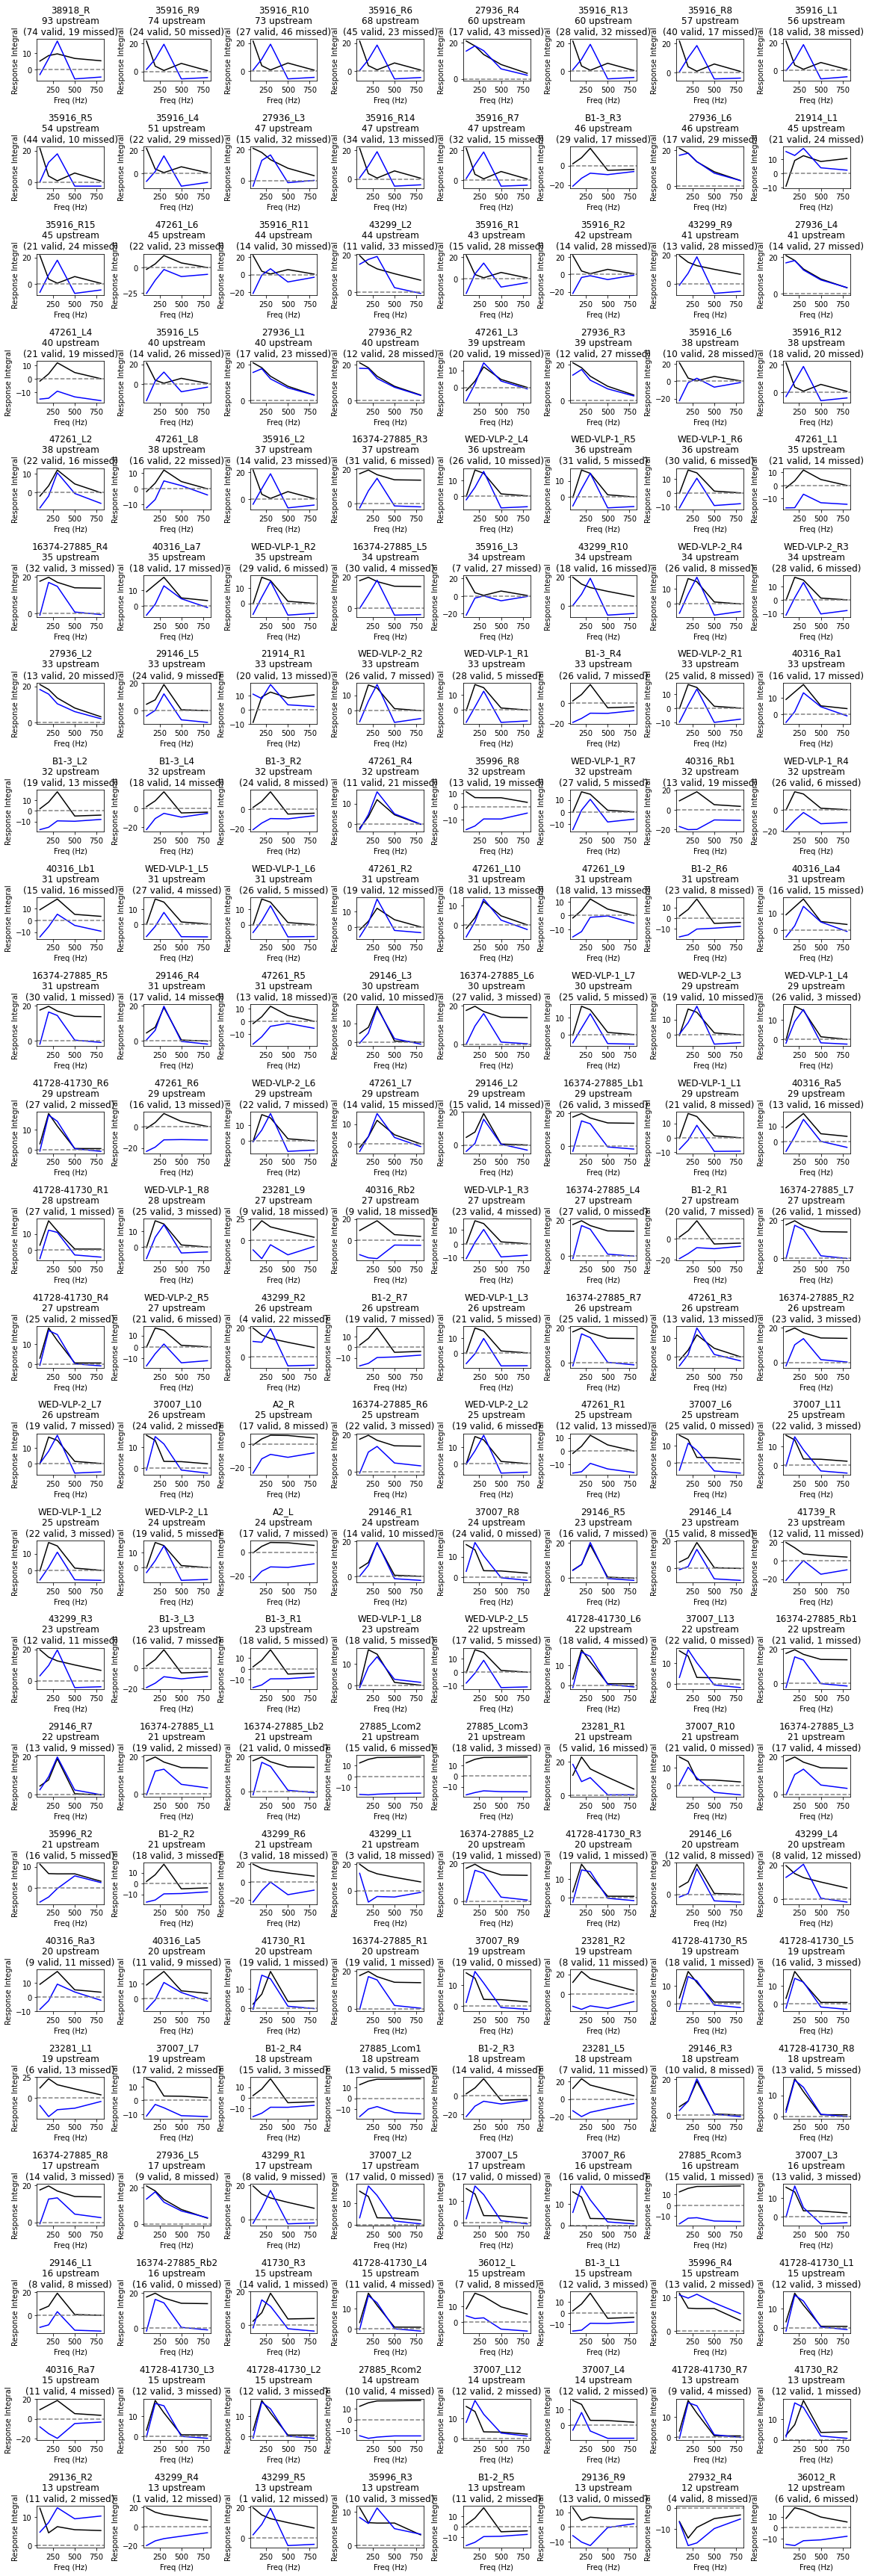

In [10]:
print(f'{len(tuning_curves_model_all)} valid tuning curve analyses')
print(f'{n_skipped} skipped')
fig, axs = plt.subplots(24, 8, figsize=(16, 48), tight_layout=True)
keys = list(tuning_curves_model_all.keys())

for key, ax in zip(keys, axs.flatten()):
    tuning_data = tuning_curves_data_all[key]
    tuning_model = tuning_curves_model_all[key]
    ax.plot(freq, tuning_data, c='k')
    ax.plot(freq, tuning_model, c='b')
    ax.axhline(0, ls='--', color='gray')

    ax.set_xlabel('Freq (Hz)')
    ax.set_ylabel('Response Integral')
    
    ax.set_title(f'{key}\n{len(labels_up_total_all[key])} upstream\n({len(labels_up_valid_all[key])} valid, {len(labels_up_missing_all[key])} missed)')
    
fig.savefig('plots/sine_freq_tuning_all.pdf')

In [11]:
df_summary_columns = [
    'LABEL', 'W_ROW_COL', 'HAS_LINE', 'LINE', 'HAS_IPI', 'HAS_FREQ',
    'N_PRE_TOTAL', 'N_PRE_EXC', 'N_PRE_INH', 'N_PRE_WITH_IPI', 'N_PRE_WITH_FREQ', 'N_PRE_WITHOUT_IPI', 'N_PRE_WITHOUT_FREQ',
    'ALL_PRE', 'PRE_WITH_IPI', 'PRE_WITH_FREQ', 'PRE_WITHOUT_IPI', 'PRE_WITHOUT_FREQ',
    'FREQ_RESPONSE_ERROR', 'FREQ_TUNING_ERROR'
]
df_summary_data = []

for cnrn, label in enumerate(labels_w):
    data_dict = {'LABEL': label, 'W_ROW_COL': cnrn}
    
    data_dict['HAS_IPI'] = (get_ipi_timecourses(label) is not None)
    data_dict['HAS_FREQ'] = (get_freq_timecourses(label) is not None)
    
    if not np.isnan(label2line[label]):
        data_dict['HAS_LINE'] = True
        data_dict['LINE'] = label2line[label]
    else:
        data_dict['HAS_LINE'] = False
        data_dict['LINE'] = np.nan
    
    inrns_pre = np.nonzero(np.abs(w[:, cnrn]) > 0)[0]
    labels_pre = labels_w[inrns_pre]
    
    data_dict['N_PRE_TOTAL'] = len(inrns_pre)
    data_dict['N_PRE_EXC'] = np.sum(w[:, cnrn] > 0)
    data_dict['N_PRE_INH'] = np.sum(w[:, cnrn] < 0)
    
    data_dict['ALL_PRE'] = '[' + ' '.join([label_pre for label_pre in labels_pre]) + ']'
    
    labels_pre_with_ipi = []
    labels_pre_with_freq = []
    
    labels_pre_without_ipi = []
    labels_pre_without_freq = []
    
    for label_pre in labels_pre:
        
        if get_ipi_timecourses(label_pre) is not None:
            labels_pre_with_ipi.append(label_pre)
        else:
            labels_pre_without_ipi.append(label_pre)
            
        if get_freq_timecourses(label_pre) is not None:
            labels_pre_with_freq.append(label_pre)
        else:
            labels_pre_without_freq.append(label_pre)
    
    data_dict['N_PRE_WITH_IPI'] = len(labels_pre_with_ipi)
    data_dict['N_PRE_WITH_FREQ'] = len(labels_pre_with_freq)
    
    data_dict['N_PRE_WITHOUT_IPI'] = len(labels_pre_without_ipi)
    data_dict['N_PRE_WITHOUT_FREQ'] = len(labels_pre_without_freq)
    
    data_dict['PRE_WITH_IPI'] = '[' + ' '.join([label_pre for label_pre in labels_pre_with_ipi]) + ']'
    data_dict['PRE_WITH_FREQ'] = '[' + ' '.join([label_pre for label_pre in labels_pre_with_freq]) + ']'
    
    data_dict['PRE_WITHOUT_IPI'] = '[' + ' '.join([label_pre for label_pre in labels_pre_without_ipi]) + ']'
    data_dict['PRE_WITHOUT_FREQ'] = '[' + ' '.join([label_pre for label_pre in labels_pre_without_freq]) + ']'
    
    data_dict['FREQ_RESPONSE_ERROR'] = rsp_err_all[label]
    data_dict['FREQ_TUNING_ERROR'] = tuning_err_all[label]
    
    df_summary_data.append(data_dict)
    
df_summary = pd.DataFrame(columns=df_summary_columns, data=df_summary_data).to_csv('data/simple/cell_summary_freq.csv', index=False)